# Puzzle Solving in Diffusion Custume

I propose a new unsupervised deep learning model based on previous work of puzzle solving and in the spirit of diffusion models.  
The goal of this work is to solve iteraively jigsaw puzzles by recovering images from shuffled versions of it.  
This is done by learning the inverse permutation matrix in reliance of time phase.     
Each timestep *t* corresponds to a certain step in the solving procedure.  
The model outputs for eache piece(patch) a probability distribution of how likely for piece to originated from a location on the image grid.  
Aspired by the way children solve puzzles, starting with most confident pieces, I use the model's output  
to take the k-best pieces and first permute those to their suggested location. This is done by solving the k-cardinality assignment problem  
with a modification of the Hungarian Algorithm.  
As we progress with the solving process, we decay *k* to ensure convergence.   

**Sources:**
- LEARNING LATENT PERMUTATIONS WITH GUMBELSINKHORN NETWORKS, [Paper.](https://arxiv.org/pdf/1802.08665.pdf)
- DeepPermNet: Visual Permutation Learning, [Paper.](https://basurafernando.github.io/papers/CVPR_2017_DeepPermNet.pdf)
- Diffusion Models Beat GANs on Image Synthesis, [Paper.](https://arxiv.org/abs/2105.05233)
- Solving the k-cardinality assignment problem by transformation, [Paper.](https://www.sciencedirect.com/science/article/pii/S0377221703002054)
- Attention Is All You Need, [Paper.](https://arxiv.org/pdf/1706.03762.pdf)
- Github implementation [Denoising Diffusion Pytorch.](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook.](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)

## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

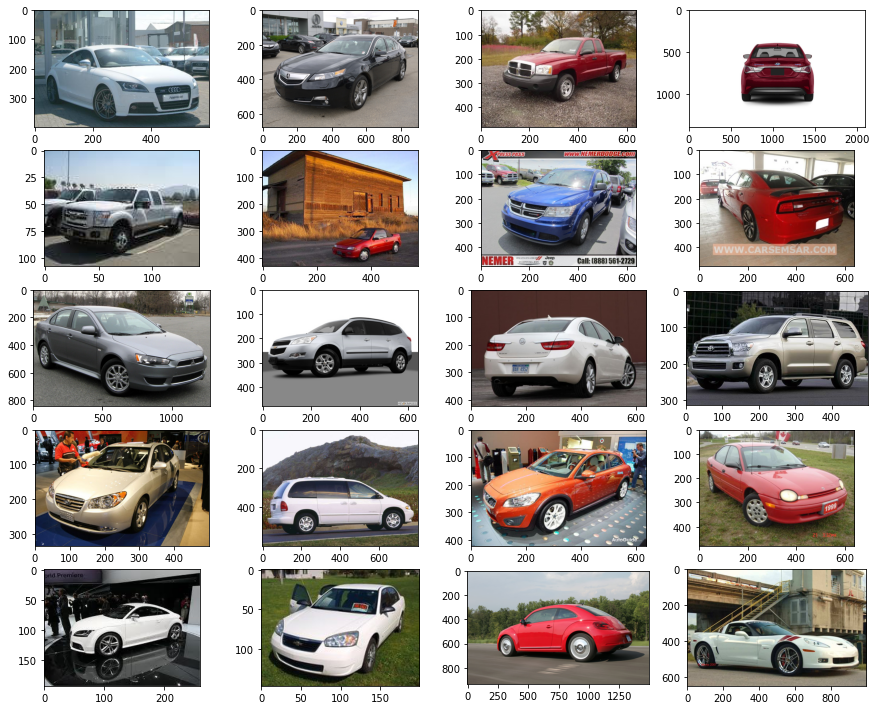

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from torch import nn
from matplotlib.lines import Line2D

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples//cols + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

# HyperParameters

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 16
patch_size = 64
number_of_patches = (IMG_SIZE // patch_size)**2
T = 50

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors etc. 

# Building the Model


## Step 1: The forward process = Patch Shuffling




We first need to build the inputs for our model, which are more and more shuffled images. Instead of doing this sequentially, we can use the composition of permutations for any of the timesteps individually. 

In [3]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class ShufflePatches(object):
  def __init__(self, patch_size):
    self.ps = patch_size

  def __call__(self, x, perm):
    # divide the batch of images into non-overlapping patches
    u = F.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
    # permute the patches of each image in the batch
    # torch.randperm(b_.shape[-1])
    pu = torch.cat([b_[:, perm][None,...] for b_ in u], dim=0)
    # fold the permuted patches back together
    f = F.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    return f

def create_single_perm(number_of_patches):
    swap_idx = torch.randint(number_of_patches, (2,))
    perm = torch.arange(number_of_patches)
    perm[swap_idx] = torch.tensor([swap_idx[1], swap_idx[0]])
    return perm


def compose(a, b):
    return a[b]


def forward_shuffle(img, t, patch_size = 8, identity_prob=0.7):
    permutations = [create_single_perm(number_of_patches) for _ in range(t)]
    shuffle = ShufflePatches(patch_size)
    
    if torch.rand(1) < identity_prob*((T-t+1)/T):
        return img, torch.arange(number_of_patches), torch.arange(number_of_patches)
    
    c = torch.arange(number_of_patches)
    for p in permutations:
        c = compose(p, c)
    last = c if t==0 else permutations[-1]
    return shuffle(img, c), c, last

cuda


Let's test it on our dataset ...

In [4]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
# data = torch.utils.data.Subset(data, range(160))

train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# subset_dataset = torch.utils.data.Subset(data, range(len(data)-10, len(data)))
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)


number of batches in train: 9, number of test images: 16


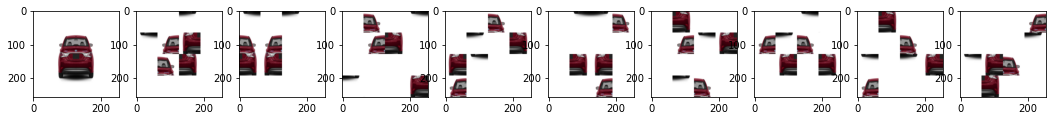

In [5]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(20,20))
plt.axis('off')
num_images = 10
stepsize = int(T//num_images)
for idx in range(0, T, stepsize):
    t = idx
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    per_img, permutation, last = forward_shuffle(image, t, patch_size, identity_prob=0)
    show_tensor_image(per_img)

print(f"number of batches in train: {len(dataloader)}, number of test images: {len(testloader)}")

## Step 2: The backward process



Here we build the network which consist of:
- Backbone network for encoding image patches.
- Sinusoidal embedding to encode the timestep.
- Sinkhorn normalization layer to enforce bistochastic permutation matrix.

The Deep Permutation Network encapsulate all of the above.

In [6]:
class SinkhornLayer(nn.Module):
    def __init__(self, temperature, n_iterations=20):
        super().__init__()
        self.temperature = temperature
        self.n_iterations = n_iterations

    def forward(self, log_alpha):
        log_alpha = log_alpha/self.temperature
        n = log_alpha.size()[1]
        log_alpha = log_alpha.view(-1, n, n)

        noise = torch.empty_like(log_alpha, device=device).uniform_(0, 1)
        noise = torch.log(noise)
        log_alpha = log_alpha+noise
        
        for i in range(self.n_iterations):
            # torch.logsumexp(input, dim, keepdim, out=None)
            #Returns the log of summed exponentials of each row of the input tensor in the given dimension dim
            #log_alpha -= (torch.logsumexp(log_alpha, dim=2, keepdim=True)).view(-1, n, 1)
            #log_alpha -= (torch.logsumexp(log_alpha, dim=1, keepdim=True)).view(-1, 1, n)
            #avoid in-place
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=2, keepdim=True)).view(-1, n, 1)
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=1, keepdim=True)).view(-1, 1, n)
        return torch.exp(log_alpha)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, output_dim, kernel_size=(5,5)):
        super().__init__()
        c, h, w = input_size
        self.output_dim = output_dim
        # self.patch_conv = 
        self.conv1 = nn.Conv2d(c, hidden_dim, kernel_size)
        self.time_mlp1 = nn.Linear(32, hidden_dim)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_dim, 16, kernel_size)
        self.time_mlp2 = nn.Linear(32, 16)

        h_out = (((h-(kernel_size[0]-1)-1+1)//2)-4)//2
        self.fc1 = nn.Linear(16 * h_out * h_out, 120)
        self.fc2 = nn.Linear(120, output_dim)

    def forward(self, x, t):
        time_emb = F.relu(self.time_mlp1(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        x = self.pool(F.relu(self.conv1(x)))
        x = x + time_emb
        time_emb = F.relu(self.time_mlp2(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        x = self.pool(F.relu(self.conv2(x)))
        x = x + time_emb
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class VggEncoder(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, output_dim, kernel_size=(5,5)):
        super().__init__()
        c, h, w = input_size
        self.output_dim = output_dim
        # self.patch_conv = 
        self.vgg = torchvision.models.vgg11(weights='DEFAULT')
        self.vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=output_dim, bias=True)

        self.time_mlp1 = nn.Linear(32, output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)

    def forward(self, x, t):
        time_emb = F.relu(self.time_mlp1(t))
        # Extend last 2 dimensions
        # time_emb = time_emb[(..., ) + (None, ) * 2]
        x = self.vgg(x)
        x = x + time_emb
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = self.fc2(x)
        return x


class PermNet(torch.nn.Module):
    def __init__(self, encoder, encoder_out_size, input_size, patch_size):
        super().__init__()
        self.encoder = encoder
        number_of_patches = (input_size // patch_size)**2
        self.output_size = number_of_patches
        self.patch_size = patch_size
        self.fc1 = nn.Linear(encoder_out_size, self.output_size)

        self.sinkhorn = SinkhornLayer(temperature=0.7, n_iterations=10)

        # Time embedding
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

    def forward(self, x, t):
        batch_size = x.shape[0]
        x = x.unfold(2, self.patch_size, self.patch_size)
        x = x.unfold(3, self.patch_size, self.patch_size)
        # (#n_pieces, channels, patch_size, patch_size)
        x = x.permute(0,2,3,1,4,5)
        x = x.reshape(-1,3,self.patch_size,self.patch_size)

        time_emb = self.time_mlp(t)
        x = self.encoder(x, time_emb)
        x = self.fc1(x)
        #reshape to cubic for sinkhorn operation
        x = x.reshape(batch_size, self.output_size, self.output_size)
        x = self.sinkhorn(x)
        # x, log_alpha_w_noise = my_gumbel_sinkhorn(x, temperature, samples_per_num, noise_factor,  n_iter_sinkhorn, squeeze=False)
        x = x.reshape(batch_size, self.output_size, self.output_size)

        return x

# with torch.no_grad():
#     a = torch.rand(1,3,256,256)
#     E = Encoder((3,32,32),64,64)
#     # E(a)
#     P = PermNet(E, 64, 64, 32)
#     p = P(a, t = torch.full((1,), 1, device='cpu', dtype=torch.long))
    # print(p.shape)
    # print(p)
#     plt.imshow(p.numpy().reshape(64,64))

### More Detailed:

Sinusoidal positional embeddings generates a embeddings using `sin` and `cos` functions. By using the equations:
$$
PE_{pos,2i} = sin(pos\cdot \omega_{i}) \\ 
PE_{pos,2i+1} = cos(pos\cdot \omega_{i}), \\ 
\omega_{i} = \frac{1}{100000^{2i/d_{model}}}
$$
where *pos* is the position and *i* is the indices of each of the positional embedding dimension. $d_{model}$ is the size of the embedding.  
Positional encodings is a finite dimensional representation of the location of an item, we hypothesize it would allow the model to learn the relative positions of the inputs.  
The Sinkhorn normalization process converts a matrix into a bistochastic matrix by repeatedly performing row and column normalizations.  
We define the Sinkhorn operator $S(X)$:
$$
S^0(X) = exp(X), \\ 
S^l = C(R(S^{l-1}(X), \\
S(X) = \lim_{x \to \infty} S^{l}(X)
$$
Considering $A$ to be matrix filled with ones and the element-wise division operation, thes:
$$
C(X) = X/AX, \\ 
R(X) = X/XA 
$$
Here I add a noise term $\epsilon = 10^{-3}$ to stabilize the process, and temperature parameter $\tau$: 
$$
\lim_{\tau \to 0}  S(X/ \tau) = M(X)
$$
Where $M(X)$ is the closest permutation matrix to $X$ under Forbenius norm.  

## Step 3: The loss



- Using MSE between inverse permutation and output.
- During testing we use LAP solving to find closest permutation matrix to the bistochastic output matrix.
- In the spirit of diffusion models, we start by taking the k-best permutation. As the timestep drops, so does *k*.

In [7]:
def per2mat(p):
    N = len(p)
    P = torch.zeros((N,N))
    P[torch.arange(N), p] = 1
    return P

def mat2per(P):
    N = len(P)
    p = torch.argmax(P, dim=0)
    return p

from scipy.optimize import linear_sum_assignment
def mat2perHard(P, dummy):
    row_ind, col_ind = linear_sum_assignment(P.cpu().numpy(), maximize=True)
    p = col_ind
    return p

def k_assign(assignment, n):
    """ get k-assigment, put unchanged pieces at their place
    and then put the rest of pieces"""
    diff = np.setdiff1d(np.arange(n),assignment)
    for i in diff:
        if assignment[i] >= n:
            assignment[i] = i
    diff = np.setdiff1d(np.arange(n),assignment)
    assignment[assignment>=n]= diff
    return assignment

def k_mat2perHard(P, k):
    P_numpy = P.cpu().numpy()
    m, n = P_numpy.shape
    N = m - k 
    
    new_cost_P = np.concatenate([P_numpy, 2*np.ones((m,N))], axis=1)
    row_ind, col_ind = linear_sum_assignment(new_cost_P, maximize=True)
    p = col_ind
    p = k_assign(p, len(p))
    return p

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tracks all the previous images for gradient calculation 

In [8]:
E = Encoder((3,patch_size,patch_size),64,64)
vgg = VggEncoder((3,patch_size,patch_size),64,64)
model = PermNet(vgg, 64, 256, patch_size)
model = model.to(device)


In [9]:
@torch.no_grad()
def sample_timestep(model, x, t, patch_size):
    P = model(x, t)
    P = P.squeeze()
    # P = P.permute(1,0)
    k = min(1+t.item()//2, P.shape[0])
    p = k_mat2perHard(P, k)
    x_t_minus = ShufflePatches(patch_size)(x, p)
    return x_t_minus, p

@torch.no_grad()
def sample_plot_image(model, patch_size):
    img_size = IMG_SIZE
    img = next(iter(testloader))[0].to(device=device)
    # shuffle 
    img, p_true, p_last = forward_shuffle(img, T, patch_size=patch_size)
    # num_images = T
    stepsize = int(T/num_images)
    
    fig = plt.figure(figsize=(20,20))
    plt.axis('off')
    # plt.subplot(1, num_images+1, num_images+1)
    ax = fig.add_subplot(1, num_images+1, num_images+1)
    ax.set_title("input shuffled")

    show_tensor_image(img.detach().cpu())
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img, p = sample_timestep(model, img, t, patch_size)
        if i % stepsize == 0:
            plt.subplot(1, num_images+1, i//stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()    

## Training

In [10]:
@torch.no_grad()
def heat(arr):
    fig = plt.figure(figsize=(8,8))
    arr = arr.cpu().numpy()
    heatmap = plt.pcolor(arr)
    plt.gca().invert_yaxis()

    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.2f' % arr[y, x],
                    horizontalalignment='center',
                    verticalalignment='center',
                    )
    plt.colorbar(heatmap)
    plt.show()

In [11]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-5)
epochs = 100 # Try more!

criterion = torch.nn.MSELoss()
model.train()
for epoch in range(epochs):
    for step, (image, label) in enumerate(dataloader):
        optimizer.zero_grad()

        # Todo - shuffle batch differently
        # t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        t = torch.randint(0, T, (1,), device=device).long()
        per_img, permutation, last_perm = forward_shuffle(image, t.item(), patch_size)
        permutation_prediction = model(per_img.to(device), t)
        ground_truth = per2mat(permutation).permute(1,0).to(device)
        ground_truth = ground_truth.expand(BATCH_SIZE, number_of_patches, number_of_patches)
        loss = criterion(permutation_prediction, 10*ground_truth)
        # loss = criterion(image, permutation_prediction)

        loss.backward()

        # plot_grad_flow(model.named_parameters())
        
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step} Loss: {loss.item()} ")
            # a = ppprint(np.round(permutation_prediction.cpu().detach().numpy(),2))
            # ax = plot_heatmap(np.round(permutation_prediction.cpu().detach().numpy()))
            # ax.plot()
            # if epoch % 20 == 0:
            #     heat(permutation_prediction[0])
            # ax.fig.clf()
            # print("a, ", t, mat2per(permutation_prediction))
            # print(torch.histc(permutation_prediction.cpu(), bins=15, min=0, max=1.01))

            # sample_plot_image(model, patch_size)

Epoch 0 | step 0 Loss: 6.179692268371582 
Epoch 5 | step 0 Loss: 6.161116600036621 
Epoch 10 | step 0 Loss: 6.194868087768555 
Epoch 15 | step 0 Loss: 5.859296798706055 
Epoch 20 | step 0 Loss: 6.243588924407959 
Epoch 25 | step 0 Loss: 6.148813724517822 
Epoch 30 | step 0 Loss: 5.653574466705322 
Epoch 35 | step 0 Loss: 5.9156999588012695 
Epoch 40 | step 0 Loss: 5.615750312805176 
Epoch 45 | step 0 Loss: 5.539319038391113 
Epoch 50 | step 0 Loss: 5.405975341796875 
Epoch 55 | step 0 Loss: 6.270374298095703 
Epoch 60 | step 0 Loss: 5.981020927429199 
Epoch 65 | step 0 Loss: 5.323678970336914 
Epoch 70 | step 0 Loss: 6.078221797943115 
Epoch 75 | step 0 Loss: 5.41502571105957 
Epoch 80 | step 0 Loss: 6.011861324310303 
Epoch 85 | step 0 Loss: 6.091301918029785 
Epoch 90 | step 0 Loss: 5.244915008544922 
Epoch 95 | step 0 Loss: 5.943993091583252 


## Step 4: Evaluate

Direct comparison is applied on test images to measures the fraction of pieces that are in same location as in the original image.

In [37]:
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    s = torch.empty_like(p)
    s[p] = torch.arange(p.shape[0])
    return s

def direct_comparision(p1, p2, inverse_p1=None):
    if inverse_p1 is not None:
        p1 = invert_permutation(inverse_p1)
    return torch.sum(p1==p2)

@torch.no_grad()
def direct_comparison():
    img_size = IMG_SIZE
    accuracy = []
    for step, (image, label) in enumerate(testloader):
        if step==51
            break
        img_shuffled, p_true, p_last = forward_shuffle(image, T, patch_size=patch_size)
        img = img_shuffled.to(device)
        # num_images = T
        stepsize = int(T/num_images)
        c = None    
        for i in range(0,T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img, p = sample_timestep(model, img, t, patch_size)
            p = torch.from_numpy(p)
            c = p if c is None else compose(c, p)

        plt.axis('off')
        fig = plt.figure(figsize=(12,12))
        # plt.subplot(1, num_images+1, num_images+1)
        n = 3
        ax = fig.add_subplot(1, n, 1)
        ax.set_title("original")
        show_tensor_image(image.detach().cpu())
        ax = fig.add_subplot(1, n, 2)
        ax.set_title("shuffled")
        show_tensor_image(img_shuffled.detach().cpu())
        ax = fig.add_subplot(1, n, 3)
        ax.set_title("solved")
        show_tensor_image(img.detach().cpu())
        accuracy.append(direct_comparision(None,p_true, c)/number_of_patches)
    return accuracy

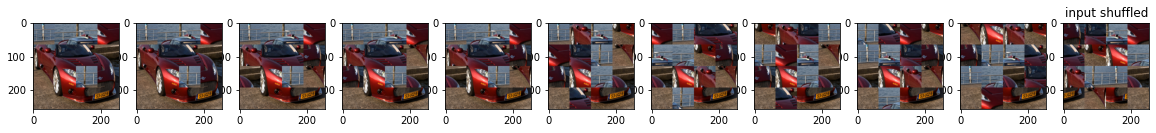

In [13]:
model.eval()
sample_plot_image(model, patch_size)

Average accuracy: 0.5284090638160706
Perfect assembly: 1


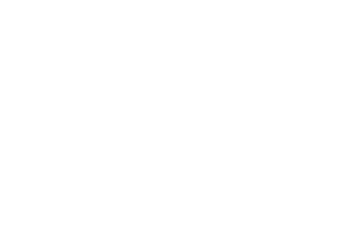

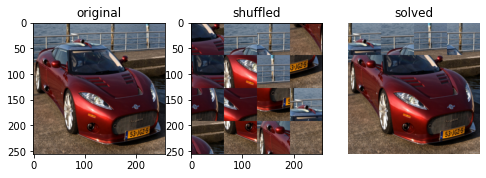

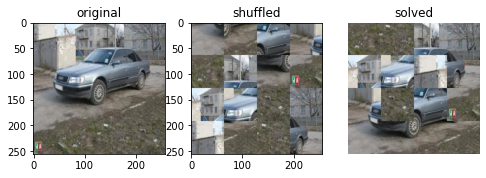

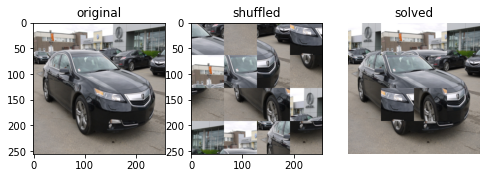

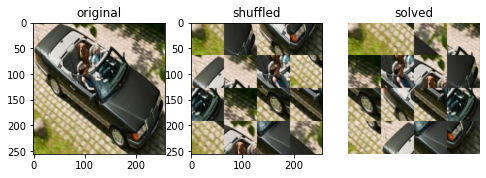

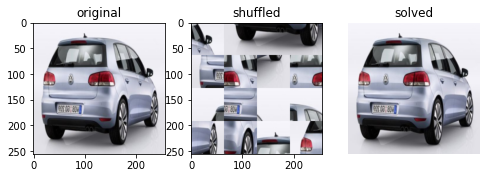

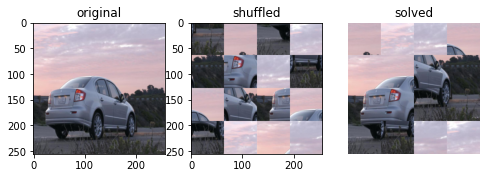

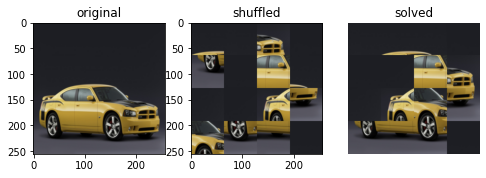

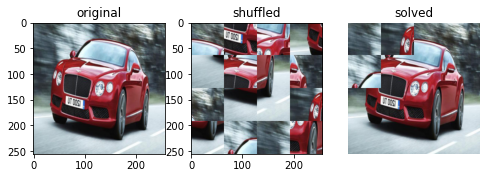

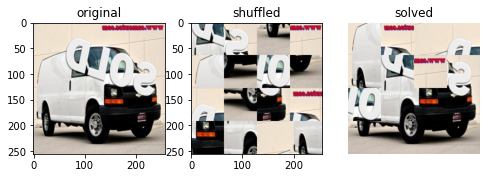

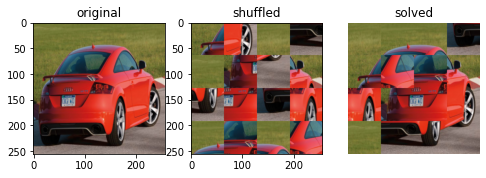

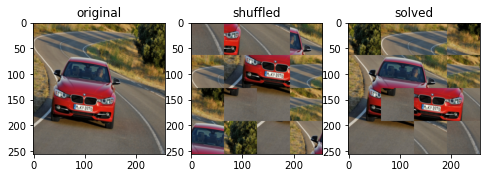

In [38]:
accuracy = direct_comparison()
print(f"Average accuracy: {np.mean(accuracy)}")
print(f"Perfect assembly: {np.sum([acc==1 for acc in accuracy]).item()}")

In [39]:
torch.save(model.state_dict(), "./model.pt")